In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import History

/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# To train on vectors made of two decks 
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)

In [2]:
decks = pd.read_csv('decks.csv', index_col=0)
# All probabilities are already in decks.csv
# prob = pd.read_csv('prob.csv', index_col=0)

Some visualisation in lower dimensions

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000)
tsne_results = tsne.fit_transform(decks.iloc[:, 0:-5])

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.007s...
[t-SNE] Computed neighbors for 400 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 2.705503


[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.960487


[t-SNE] Error after 1000 iterations: 0.144068


/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/kris/PycharmProjects/SUS/lab1/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


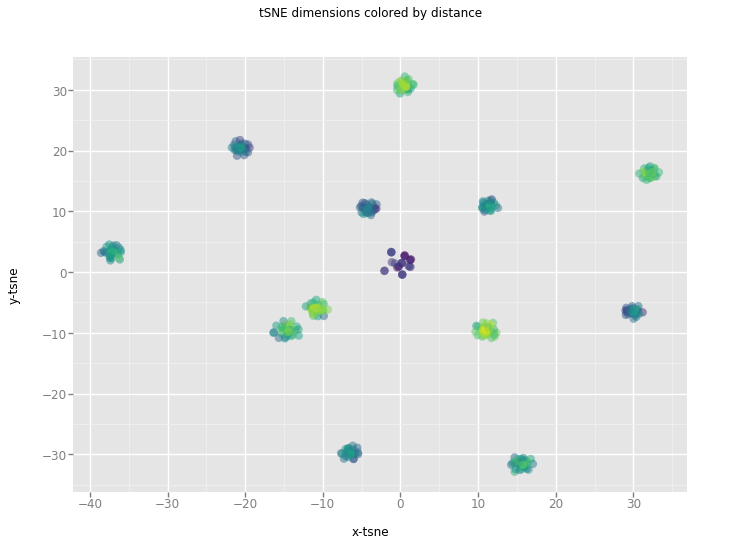

<ggplot: (8742412514217)>

In [6]:
%matplotlib inline
from ggplot import *

df_tsne = decks.copy()
df_tsne['x-tsne'] = tsne_results[:, 0]
df_tsne['y-tsne'] = tsne_results[:, 1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne')) \
        + geom_point(aes(colour='prob'), size=70, alpha=0.5) \
        + ggtitle("tSNE dimensions colored by distance")
chart

Preparing data:

In [69]:
def add_bot_dummies(old_data_set):
    """Returns new data set with 4 times more rows and dummies for four bots."""
    # Data set should not contain probabilities
    data_set = np.array(old_data_set, dtype=np.int)
    
    nrows = data_set.shape[0]
    
    data_set = np.append(data_set, data_set, axis=0)
    data_set = np.append(data_set, data_set, axis=0)
    
    bots = np.zeros((1600, 4), dtype=np.int)
    bots[0:nrows, 0] = 1
    bots[nrows:2*nrows, 1] = 1
    bots[2*nrows:3*nrows, 2] = 1
    bots[3*nrows:4*nrows, 3] = 1
    
    data_set = np.append(data_set, bots, axis=1)
    
    return data_set

In [70]:
X_train = add_bot_dummies(decks.iloc[:, 0:-5].copy())

In [71]:
def get_bots_prob(bots_prob):
    """"Given array of probabilities for four bots returns 2D array with 4 times more rows and 4 times less columns"""
    bot_1 = np.array(bots_prob.iloc[:, 0], dtype=np.float)
    bot_2 = np.array(bots_prob.iloc[:, 1], dtype=np.float)
    bot_3 = np.array(bots_prob.iloc[:, 2], dtype=np.float)
    bot_4 = np.array(bots_prob.iloc[:, 3], dtype=np.float)
    
    bots = np.append(bot_1, bot_2, axis=0)
    bots = np.append(bots, bot_3, axis=0)
    bots = np.append(bots, bot_4, axis=0)
    bots = np.expand_dims(bots, axis=1)
    
    return bots

In [72]:
y_train = get_bots_prob(decks.iloc[:, -4:].copy())

In [73]:
def shuffle_and_expand_dims(X_train, y_train):
    
    if X_train.shape[0] != y_train.shape[0]:
        print("Wrong input")
        print("Number of rows in X: " + str(X_train.shape[0]))
        print("Number of rows in y: " + str(y_train.shape[0]))
    
    temp = np.append(X_train, y_train, axis=1)
    np.random.shuffle(temp)
    X_train = temp[:, 0:-1]
    y_train = temp[:, -1]
    
    # Keras sequential needs input to have 3D and clases (and predictions) to have 2D
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=1)
    
    return X_train, y_train

In [74]:
X_train, y_train = shuffle_and_expand_dims(X_train, y_train)

In [75]:
print(X_train.shape)
print(y_train.shape)

(1600, 343, 1)
(1600, 1)


Preparation of data to treat problem as classification with single class

In [76]:
def f(x):
    if x >= 0.5:
        return 1
    return 0

In [81]:
y_train_classification = pd.DataFrame(y_train)
y_train_classification = y_train_classification.applymap(f)
#y_train_classification = np.expand_dims(np.array(y_train_classification), axis=1)

In [82]:
print(y_train_classification.shape)

(1600, 1)


Preparation of data to treat problem as classification with two classes to use softmax

In [96]:
def g(x):
    if x == 0:
        return 1
    return 0

In [100]:
y_train_classification2 = pd.DataFrame(y_train_classification).applymap(g)
y_train_classification2 = np.append(y_train_classification, np.array(y_train_classification2), axis=1)

In [101]:
print(y_train_classification2)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


Creating model:

In [107]:
batch_size = 100
num_classes = 2
nepochs = 300
learning_rate = 0.03
decay_rate = learning_rate / nepochs

In [108]:
model = Sequential()

activation_function = 'relu'

model.add(Conv1D(32, 3, padding='same', input_shape=(343, 1), activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.1))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.3))

model.add(Conv1D(32, 3, padding='same', activation=activation_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500, activation=activation_function))
#model.add(Dropout(0.4))
model.add(Dense(500, activation=activation_function))
model.add(Dense(num_classes, activation='softmax')) #sigmoid

In [109]:
#opt = keras.optimizers.RMSprop(lr=0.2)
opt = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, decay=decay_rate, nesterov=True)
#opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

Training:

In [110]:
history = model.fit(X_train, y_train_classification2, batch_size=batch_size, epochs=nepochs)

Epoch 1/300


 100/1600 [>.............................] - ETA: 8s - loss: 0.2498 - acc: 0.5100

 300/1600 [====>.........................] - ETA: 2s - loss: 0.2496 - acc: 0.5400

 500/1600 [========>.....................] - ETA: 1s - loss: 0.2494 - acc: 0.5740

 700/1600 [============>.................] - ETA: 0s - loss: 0.2492 - acc: 0.6086

 900/1600 [===============>..............] - ETA: 0s - loss: 0.2490 - acc: 0.6100

1100/1600 [===================>..........] - ETA: 0s - loss: 0.2487 - acc: 0.6218

1300/1600 [=======================>......] - ETA: 0s - loss: 0.2485 - acc: 0.6254

1500/1600 [===========================>..] - ETA: 0s - loss: 0.2483 - acc: 0.6140

1600/1600 [==============================] - 1s 661us/step - loss: 0.2482 - acc: 0.6119


Epoch 2/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.2454 - acc: 0.5500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.2452 - acc: 0.5333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.2455 - acc: 0.5100

 700/1600 [============>.................] - ETA: 0s - loss: 0.2453 - acc: 0.5143

 900/1600 [===============>..............] - ETA: 0s - loss: 0.2453 - acc: 0.5233

1100/1600 [===================>..........] - ETA: 0s - loss: 0.2448 - acc: 0.5700

1300/1600 [=======================>......] - ETA: 0s - loss: 0.2445 - acc: 0.5923

1500/1600 [===========================>..] - ETA: 0s - loss: 0.2441 - acc: 0.6200

1600/1600 [==============================] - 1s 344us/step - loss: 0.2438 - acc: 0.6294


Epoch 3/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.2397 - acc: 0.7000

 300/1600 [====>.........................] - ETA: 0s - loss: 0.2415 - acc: 0.6567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.2389 - acc: 0.6780

 700/1600 [============>.................] - ETA: 0s - loss: 0.2382 - acc: 0.6529

 900/1600 [===============>..............] - ETA: 0s - loss: 0.2384 - acc: 0.6322

1100/1600 [===================>..........] - ETA: 0s - loss: 0.2376 - acc: 0.6373

1300/1600 [=======================>......] - ETA: 0s - loss: 0.2365 - acc: 0.6546

1500/1600 [===========================>..] - ETA: 0s - loss: 0.2353 - acc: 0.6727

1600/1600 [==============================] - 1s 348us/step - loss: 0.2349 - acc: 0.6787


Epoch 4/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.2213 - acc: 0.8700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.2242 - acc: 0.7967

 500/1600 [========>.....................] - ETA: 0s - loss: 0.2206 - acc: 0.8140

 700/1600 [============>.................] - ETA: 0s - loss: 0.2199 - acc: 0.7971

 900/1600 [===============>..............] - ETA: 0s - loss: 0.2180 - acc: 0.7878

1100/1600 [===================>..........] - ETA: 0s - loss: 0.2169 - acc: 0.7800

1300/1600 [=======================>......] - ETA: 0s - loss: 0.2144 - acc: 0.7769

1500/1600 [===========================>..] - ETA: 0s - loss: 0.2110 - acc: 0.7800

1600/1600 [==============================] - 1s 346us/step - loss: 0.2086 - acc: 0.7825


Epoch 5/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.1884 - acc: 0.7700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.1863 - acc: 0.7633

 500/1600 [========>.....................] - ETA: 0s - loss: 0.1751 - acc: 0.7960

 700/1600 [============>.................] - ETA: 0s - loss: 0.1708 - acc: 0.7957

 900/1600 [===============>..............] - ETA: 0s - loss: 0.1656 - acc: 0.7967

1100/1600 [===================>..........] - ETA: 0s - loss: 0.1597 - acc: 0.8064

1300/1600 [=======================>......] - ETA: 0s - loss: 0.1548 - acc: 0.8115

1500/1600 [===========================>..] - ETA: 0s - loss: 0.1523 - acc: 0.8113

1600/1600 [==============================] - 1s 345us/step - loss: 0.1517 - acc: 0.8100


Epoch 6/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.1523 - acc: 0.7900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.1188 - acc: 0.8400

 500/1600 [========>.....................] - ETA: 0s - loss: 0.1196 - acc: 0.8380

 700/1600 [============>.................] - ETA: 0s - loss: 0.1234 - acc: 0.8286

 900/1600 [===============>..............] - ETA: 0s - loss: 0.1250 - acc: 0.8222

1100/1600 [===================>..........] - ETA: 0s - loss: 0.1242 - acc: 0.8282

1300/1600 [=======================>......] - ETA: 0s - loss: 0.1250 - acc: 0.8277

1500/1600 [===========================>..] - ETA: 0s - loss: 0.1233 - acc: 0.8313

1600/1600 [==============================] - 1s 320us/step - loss: 0.1217 - acc: 0.8331


Epoch 7/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.1001 - acc: 0.8900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.1011 - acc: 0.8767

 500/1600 [========>.....................] - ETA: 0s - loss: 0.1093 - acc: 0.8580

 700/1600 [============>.................] - ETA: 0s - loss: 0.1075 - acc: 0.8600

 900/1600 [===============>..............] - ETA: 0s - loss: 0.1018 - acc: 0.8678

1100/1600 [===================>..........] - ETA: 0s - loss: 0.1082 - acc: 0.8564

1300/1600 [=======================>......] - ETA: 0s - loss: 0.1086 - acc: 0.8585

1500/1600 [===========================>..] - ETA: 0s - loss: 0.1093 - acc: 0.8560

1600/1600 [==============================] - 0s 311us/step - loss: 0.1109 - acc: 0.8544


Epoch 8/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.1168 - acc: 0.8400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.1102 - acc: 0.8533

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0989 - acc: 0.8720

 700/1600 [============>.................] - ETA: 0s - loss: 0.1037 - acc: 0.8614

 900/1600 [===============>..............] - ETA: 0s - loss: 0.1032 - acc: 0.8622

1100/1600 [===================>..........] - ETA: 0s - loss: 0.1032 - acc: 0.8618

1300/1600 [=======================>......] - ETA: 0s - loss: 0.1027 - acc: 0.8646

1500/1600 [===========================>..] - ETA: 0s - loss: 0.1033 - acc: 0.8620

1600/1600 [==============================] - 0s 309us/step - loss: 0.1038 - acc: 0.8606


Epoch 9/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0804 - acc: 0.9000

 300/1600 [====>.........................] - ETA: 0s - loss: 0.1084 - acc: 0.8500

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0999 - acc: 0.8700

 700/1600 [============>.................] - ETA: 0s - loss: 0.0960 - acc: 0.8714

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0967 - acc: 0.8711

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0973 - acc: 0.8709

1300/1600 [=======================>......] - ETA: 0s - loss: 0.1000 - acc: 0.8662

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0977 - acc: 0.8693

1600/1600 [==============================] - 1s 317us/step - loss: 0.0966 - acc: 0.8706


Epoch 10/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0812 - acc: 0.8900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0836 - acc: 0.8900

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0848 - acc: 0.8860

 700/1600 [============>.................] - ETA: 0s - loss: 0.0966 - acc: 0.8714

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0936 - acc: 0.8778

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0918 - acc: 0.8791

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0900 - acc: 0.8831

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0914 - acc: 0.8787

1600/1600 [==============================] - 1s 317us/step - loss: 0.0904 - acc: 0.8806


Epoch 11/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.1103 - acc: 0.8600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0987 - acc: 0.8733

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0922 - acc: 0.8860

 700/1600 [============>.................] - ETA: 0s - loss: 0.0925 - acc: 0.8814

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0925 - acc: 0.8822

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0903 - acc: 0.8836

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0896 - acc: 0.8862

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0885 - acc: 0.8860

1600/1600 [==============================] - 1s 313us/step - loss: 0.0868 - acc: 0.8888


Epoch 12/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0860 - acc: 0.8800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0713 - acc: 0.9067

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0722 - acc: 0.9000

 700/1600 [============>.................] - ETA: 0s - loss: 0.0764 - acc: 0.8957

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0781 - acc: 0.8989

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0785 - acc: 0.9009

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0763 - acc: 0.9054

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0788 - acc: 0.9007

1600/1600 [==============================] - 1s 316us/step - loss: 0.0803 - acc: 0.8969


Epoch 13/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0784 - acc: 0.8900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0616 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0616 - acc: 0.9240

 700/1600 [============>.................] - ETA: 0s - loss: 0.0728 - acc: 0.9100

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0789 - acc: 0.9022

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0766 - acc: 0.9064

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0749 - acc: 0.9077

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0757 - acc: 0.9060

1600/1600 [==============================] - 1s 364us/step - loss: 0.0776 - acc: 0.9031


Epoch 14/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0783 - acc: 0.9000

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0885 - acc: 0.8867

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0821 - acc: 0.8980

 700/1600 [============>.................] - ETA: 0s - loss: 0.0745 - acc: 0.9071

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0785 - acc: 0.9022

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0728 - acc: 0.9109

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0715 - acc: 0.9115

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0739 - acc: 0.9080

1600/1600 [==============================] - 1s 333us/step - loss: 0.0740 - acc: 0.9075


Epoch 15/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0669 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0697 - acc: 0.9133

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0681 - acc: 0.9120

 700/1600 [============>.................] - ETA: 0s - loss: 0.0681 - acc: 0.9071

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0666 - acc: 0.9122

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0673 - acc: 0.9091

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0700 - acc: 0.9069

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0714 - acc: 0.9047

1600/1600 [==============================] - 1s 336us/step - loss: 0.0715 - acc: 0.9056


Epoch 16/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0610 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0802 - acc: 0.9067

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0820 - acc: 0.9000

 700/1600 [============>.................] - ETA: 0s - loss: 0.0720 - acc: 0.9086

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0691 - acc: 0.9156

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0663 - acc: 0.9182

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0695 - acc: 0.9146

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0685 - acc: 0.9140

1600/1600 [==============================] - 1s 321us/step - loss: 0.0716 - acc: 0.9087


Epoch 17/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0895 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0646 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0653 - acc: 0.9260

 700/1600 [============>.................] - ETA: 0s - loss: 0.0694 - acc: 0.9143

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0675 - acc: 0.9167

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0670 - acc: 0.9173

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0666 - acc: 0.9154

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0670 - acc: 0.9153

1600/1600 [==============================] - 1s 335us/step - loss: 0.0677 - acc: 0.9125


Epoch 18/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0743 - acc: 0.8900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0674 - acc: 0.9000

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0639 - acc: 0.9160

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0677 - acc: 0.9083

 700/1600 [============>.................] - ETA: 0s - loss: 0.0640 - acc: 0.9143

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0674 - acc: 0.9100

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0684 - acc: 0.9100

1000/1600 [=================>............] - ETA: 0s - loss: 0.0677 - acc: 0.9100

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0672 - acc: 0.9109

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0694 - acc: 0.9083

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0702 - acc: 0.9054

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0706 - acc: 0.9057

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0711 - acc: 0.9053

1600/1600 [==============================] - 1s 602us/step - loss: 0.0695 - acc: 0.9081


Epoch 19/300


 100/1600 [>.............................] - ETA: 1s - loss: 0.0763 - acc: 0.9100

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0664 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0645 - acc: 0.9167

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0717 - acc: 0.9100

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0700 - acc: 0.9133

 700/1600 [============>.................] - ETA: 0s - loss: 0.0694 - acc: 0.9114

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0697 - acc: 0.9088

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0683 - acc: 0.9111

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0711 - acc: 0.9045

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0704 - acc: 0.9054

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0700 - acc: 0.9080

1600/1600 [==============================] - 1s 659us/step - loss: 0.0700 - acc: 0.9075


Epoch 20/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0787 - acc: 0.8800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0612 - acc: 0.9167

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0678 - acc: 0.9100

 700/1600 [============>.................] - ETA: 0s - loss: 0.0615 - acc: 0.9200

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0625 - acc: 0.9189

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0657 - acc: 0.9136

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0692 - acc: 0.9100

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0699 - acc: 0.9093

1600/1600 [==============================] - 1s 361us/step - loss: 0.0677 - acc: 0.9106


Epoch 21/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0624 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0738 - acc: 0.9033

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0703 - acc: 0.9100

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0687 - acc: 0.9120

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0689 - acc: 0.9083

 700/1600 [============>.................] - ETA: 0s - loss: 0.0636 - acc: 0.9171

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0639 - acc: 0.9150

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0656 - acc: 0.9144

1000/1600 [=================>............] - ETA: 0s - loss: 0.0648 - acc: 0.9160

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0676 - acc: 0.9118

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0673 - acc: 0.9100

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0671 - acc: 0.9093

1600/1600 [==============================] - 1s 563us/step - loss: 0.0654 - acc: 0.9113


Epoch 22/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0758 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0663 - acc: 0.9233

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0613 - acc: 0.9260

 700/1600 [============>.................] - ETA: 0s - loss: 0.0655 - acc: 0.9200

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0630 - acc: 0.9200

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0658 - acc: 0.9155

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0619 - acc: 0.9215

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0657 - acc: 0.9153

1600/1600 [==============================] - 1s 395us/step - loss: 0.0653 - acc: 0.9163


Epoch 23/300


 100/1600 [>.............................] - ETA: 1s - loss: 0.0653 - acc: 0.9000

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0655 - acc: 0.9150

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0607 - acc: 0.9250

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0611 - acc: 0.9217

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0651 - acc: 0.9162

1000/1600 [=================>............] - ETA: 0s - loss: 0.0634 - acc: 0.9190

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0611 - acc: 0.9208

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0630 - acc: 0.9157

1600/1600 [==============================] - 1s 413us/step - loss: 0.0621 - acc: 0.9181


Epoch 24/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0422 - acc: 0.9500

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0570 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0575 - acc: 0.9267

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0602 - acc: 0.9175

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0585 - acc: 0.9220

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0646 - acc: 0.9133

 700/1600 [============>.................] - ETA: 0s - loss: 0.0630 - acc: 0.9157

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0633 - acc: 0.9163

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0650 - acc: 0.9133

1000/1600 [=================>............] - ETA: 0s - loss: 0.0638 - acc: 0.9150

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0615 - acc: 0.9173

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0626 - acc: 0.9142

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0635 - acc: 0.9123

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0637 - acc: 0.9129

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0647 - acc: 0.9113

1600/1600 [==============================] - 1s 623us/step - loss: 0.0645 - acc: 0.9113


Epoch 25/300


 100/1600 [>.............................] - ETA: 1s - loss: 0.0511 - acc: 0.9300

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0665 - acc: 0.9050

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0665 - acc: 0.9033

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0670 - acc: 0.8975

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0713 - acc: 0.8940

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0655 - acc: 0.9033

 700/1600 [============>.................] - ETA: 0s - loss: 0.0625 - acc: 0.9086

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0610 - acc: 0.9125

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0617 - acc: 0.9133

1000/1600 [=================>............] - ETA: 0s - loss: 0.0611 - acc: 0.9160

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0628 - acc: 0.9145

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0632 - acc: 0.9150

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0639 - acc: 0.9138

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0636 - acc: 0.9129

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0636 - acc: 0.9127

1600/1600 [==============================] - 1s 692us/step - loss: 0.0623 - acc: 0.9137


Epoch 26/300


 100/1600 [>.............................] - ETA: 1s - loss: 0.0659 - acc: 0.9200

 200/1600 [==>...........................] - ETA: 1s - loss: 0.0702 - acc: 0.9150

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0762 - acc: 0.9000

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0761 - acc: 0.9000

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0721 - acc: 0.9080

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0711 - acc: 0.9083

 700/1600 [============>.................] - ETA: 0s - loss: 0.0722 - acc: 0.9057

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0718 - acc: 0.9075

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0714 - acc: 0.9067

1000/1600 [=================>............] - ETA: 0s - loss: 0.0707 - acc: 0.9070

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0695 - acc: 0.9082

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0683 - acc: 0.9100

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0687 - acc: 0.9100

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0688 - acc: 0.9093

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0673 - acc: 0.9113

1600/1600 [==============================] - 1s 688us/step - loss: 0.0655 - acc: 0.9125


Epoch 27/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0351 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0577 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0576 - acc: 0.9280

 700/1600 [============>.................] - ETA: 0s - loss: 0.0607 - acc: 0.9200

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0596 - acc: 0.9211

1000/1600 [=================>............] - ETA: 0s - loss: 0.0587 - acc: 0.9200

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0582 - acc: 0.9209

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0590 - acc: 0.9208

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0596 - acc: 0.9192

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0603 - acc: 0.9186

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0618 - acc: 0.9153

1600/1600 [==============================] - 1s 446us/step - loss: 0.0620 - acc: 0.9150


Epoch 28/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0642 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0737 - acc: 0.8933

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0662 - acc: 0.9060

 700/1600 [============>.................] - ETA: 0s - loss: 0.0584 - acc: 0.9200

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0626 - acc: 0.9144

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0632 - acc: 0.9155

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0630 - acc: 0.9138

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0626 - acc: 0.9127

1600/1600 [==============================] - 1s 332us/step - loss: 0.0614 - acc: 0.9156


Epoch 29/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0538 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0523 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0587 - acc: 0.9200

 700/1600 [============>.................] - ETA: 0s - loss: 0.0602 - acc: 0.9186

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0617 - acc: 0.9144

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0607 - acc: 0.9191

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0590 - acc: 0.9200

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0597 - acc: 0.9180

1600/1600 [==============================] - 1s 391us/step - loss: 0.0612 - acc: 0.9138


Epoch 30/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0577 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0574 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0537 - acc: 0.9320

 700/1600 [============>.................] - ETA: 0s - loss: 0.0541 - acc: 0.9286

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0570 - acc: 0.9225

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0565 - acc: 0.9233

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0598 - acc: 0.9191

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0631 - acc: 0.9146

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0604 - acc: 0.9180

1600/1600 [==============================] - 1s 403us/step - loss: 0.0605 - acc: 0.9188


Epoch 31/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0570 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0681 - acc: 0.9167

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0707 - acc: 0.9140

 700/1600 [============>.................] - ETA: 0s - loss: 0.0620 - acc: 0.9229

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0624 - acc: 0.9225

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0647 - acc: 0.9200

1000/1600 [=================>............] - ETA: 0s - loss: 0.0641 - acc: 0.9210

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0623 - acc: 0.9225

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0638 - acc: 0.9193

1600/1600 [==============================] - 1s 404us/step - loss: 0.0618 - acc: 0.9206


Epoch 32/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0467 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0634 - acc: 0.9133

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0642 - acc: 0.9100

 700/1600 [============>.................] - ETA: 0s - loss: 0.0627 - acc: 0.9100

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0643 - acc: 0.9100

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0677 - acc: 0.9082

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0645 - acc: 0.9131

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0638 - acc: 0.9140

1600/1600 [==============================] - 1s 326us/step - loss: 0.0621 - acc: 0.9169


Epoch 33/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0789 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0700 - acc: 0.9067

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0684 - acc: 0.9100

 700/1600 [============>.................] - ETA: 0s - loss: 0.0731 - acc: 0.9029

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0657 - acc: 0.9122

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0623 - acc: 0.9182

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0594 - acc: 0.9208

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0614 - acc: 0.9173

1600/1600 [==============================] - 1s 329us/step - loss: 0.0607 - acc: 0.9175


Epoch 34/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0670 - acc: 0.9100

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0791 - acc: 0.9000

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0752 - acc: 0.8950

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0665 - acc: 0.9050

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0596 - acc: 0.9162

1000/1600 [=================>............] - ETA: 0s - loss: 0.0616 - acc: 0.9150

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0611 - acc: 0.9183

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0628 - acc: 0.9150

1600/1600 [==============================] - 1s 434us/step - loss: 0.0599 - acc: 0.9187


Epoch 35/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0660 - acc: 0.9000

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0638 - acc: 0.9100

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0643 - acc: 0.9150

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0643 - acc: 0.9183

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0626 - acc: 0.9213

1000/1600 [=================>............] - ETA: 0s - loss: 0.0642 - acc: 0.9180

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0625 - acc: 0.9192

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0608 - acc: 0.9214

1600/1600 [==============================] - 1s 416us/step - loss: 0.0602 - acc: 0.9200


Epoch 36/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0800 - acc: 0.9000

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0682 - acc: 0.9000

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0701 - acc: 0.9050

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0675 - acc: 0.9017

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0662 - acc: 0.9050

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0662 - acc: 0.9033

1000/1600 [=================>............] - ETA: 0s - loss: 0.0646 - acc: 0.9080

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0614 - acc: 0.9133

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0614 - acc: 0.9131

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0604 - acc: 0.9157

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0604 - acc: 0.9167

1600/1600 [==============================] - 1s 473us/step - loss: 0.0602 - acc: 0.9163


Epoch 37/300


 100/1600 [>.............................] - ETA: 1s - loss: 0.0685 - acc: 0.9000

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0558 - acc: 0.9250

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0522 - acc: 0.9233

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0599 - acc: 0.9125

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0603 - acc: 0.9180

 700/1600 [============>.................] - ETA: 0s - loss: 0.0565 - acc: 0.9214

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0558 - acc: 0.9256

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0564 - acc: 0.9245

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0579 - acc: 0.9254

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0588 - acc: 0.9240

1600/1600 [==============================] - 1s 422us/step - loss: 0.0599 - acc: 0.9231


Epoch 38/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0379 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0394 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0517 - acc: 0.9300

 700/1600 [============>.................] - ETA: 0s - loss: 0.0582 - acc: 0.9214

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0560 - acc: 0.9222

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0581 - acc: 0.9173

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0583 - acc: 0.9169

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0570 - acc: 0.9193

1600/1600 [==============================] - 1s 325us/step - loss: 0.0589 - acc: 0.9163


Epoch 39/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0835 - acc: 0.8500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0555 - acc: 0.9200

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0603 - acc: 0.9200

 700/1600 [============>.................] - ETA: 0s - loss: 0.0609 - acc: 0.9157

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0560 - acc: 0.9222

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0573 - acc: 0.9182

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0550 - acc: 0.9231

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0576 - acc: 0.9193

1600/1600 [==============================] - 1s 327us/step - loss: 0.0599 - acc: 0.9169


Epoch 40/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0714 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0495 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0573 - acc: 0.9320

 700/1600 [============>.................] - ETA: 0s - loss: 0.0575 - acc: 0.9300

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0600 - acc: 0.9244

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0604 - acc: 0.9209

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0597 - acc: 0.9223

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0585 - acc: 0.9240

1600/1600 [==============================] - 1s 325us/step - loss: 0.0583 - acc: 0.9244


Epoch 41/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0273 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0371 - acc: 0.9567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0525 - acc: 0.9280

 700/1600 [============>.................] - ETA: 0s - loss: 0.0571 - acc: 0.9229

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0594 - acc: 0.9178

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0557 - acc: 0.9227

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0596 - acc: 0.9162

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0603 - acc: 0.9147

1600/1600 [==============================] - 1s 332us/step - loss: 0.0600 - acc: 0.9156


Epoch 42/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0845 - acc: 0.8900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0723 - acc: 0.9000

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0752 - acc: 0.8980

 700/1600 [============>.................] - ETA: 0s - loss: 0.0682 - acc: 0.9057

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0680 - acc: 0.9067

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0643 - acc: 0.9109

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0631 - acc: 0.9131

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0593 - acc: 0.9167

1600/1600 [==============================] - 1s 325us/step - loss: 0.0590 - acc: 0.9169


Epoch 43/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0494 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0618 - acc: 0.9167

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0565 - acc: 0.9220

 700/1600 [============>.................] - ETA: 0s - loss: 0.0517 - acc: 0.9314

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0542 - acc: 0.9244

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0521 - acc: 0.9264

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0543 - acc: 0.9223

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0560 - acc: 0.9207

1600/1600 [==============================] - 1s 329us/step - loss: 0.0565 - acc: 0.9200


Epoch 44/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0512 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0562 - acc: 0.9233

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0570 - acc: 0.9240

 700/1600 [============>.................] - ETA: 0s - loss: 0.0536 - acc: 0.9286

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0560 - acc: 0.9267

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0548 - acc: 0.9273

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0570 - acc: 0.9223

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0582 - acc: 0.9207

1600/1600 [==============================] - 1s 317us/step - loss: 0.0587 - acc: 0.9187


Epoch 45/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0538 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0543 - acc: 0.9233

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0635 - acc: 0.9060

 700/1600 [============>.................] - ETA: 0s - loss: 0.0566 - acc: 0.9200

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0536 - acc: 0.9244

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0589 - acc: 0.9182

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0599 - acc: 0.9169

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0581 - acc: 0.9207

1600/1600 [==============================] - 1s 324us/step - loss: 0.0574 - acc: 0.9219


Epoch 46/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0543 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0577 - acc: 0.9167

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0546 - acc: 0.9300

 700/1600 [============>.................] - ETA: 0s - loss: 0.0528 - acc: 0.9314

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0576 - acc: 0.9244

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0572 - acc: 0.9255

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0586 - acc: 0.9215

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0571 - acc: 0.9233

1600/1600 [==============================] - 1s 321us/step - loss: 0.0574 - acc: 0.9231


Epoch 47/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0385 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0462 - acc: 0.9400

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0477 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0536 - acc: 0.9257

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0517 - acc: 0.9289

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0515 - acc: 0.9291

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0561 - acc: 0.9223

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0565 - acc: 0.9207

1600/1600 [==============================] - 1s 321us/step - loss: 0.0569 - acc: 0.9200


Epoch 48/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0273 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0537 - acc: 0.9200

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0607 - acc: 0.9100

 700/1600 [============>.................] - ETA: 0s - loss: 0.0651 - acc: 0.9071

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0629 - acc: 0.9111

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0610 - acc: 0.9136

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0582 - acc: 0.9177

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0570 - acc: 0.9180

1600/1600 [==============================] - 1s 327us/step - loss: 0.0571 - acc: 0.9188


Epoch 49/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0430 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0452 - acc: 0.9367

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0570 - acc: 0.9220

 700/1600 [============>.................] - ETA: 0s - loss: 0.0598 - acc: 0.9157

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0652 - acc: 0.9100

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0619 - acc: 0.9155

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0587 - acc: 0.9192

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0568 - acc: 0.9220

1600/1600 [==============================] - 1s 341us/step - loss: 0.0560 - acc: 0.9244


Epoch 50/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0597 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0523 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0496 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0507 - acc: 0.9314

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0511 - acc: 0.9289

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0533 - acc: 0.9236

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0555 - acc: 0.9223

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0567 - acc: 0.9213

1600/1600 [==============================] - 1s 328us/step - loss: 0.0564 - acc: 0.9219


Epoch 51/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0209 - acc: 0.9900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0432 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0498 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0524 - acc: 0.9343

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0531 - acc: 0.9278

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0585 - acc: 0.9209

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0591 - acc: 0.9192

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0583 - acc: 0.9207

1600/1600 [==============================] - 1s 329us/step - loss: 0.0573 - acc: 0.9225


Epoch 52/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0498 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0509 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0488 - acc: 0.9360

 700/1600 [============>.................] - ETA: 0s - loss: 0.0516 - acc: 0.9271

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0493 - acc: 0.9300

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0476 - acc: 0.9318

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0514 - acc: 0.9262

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0534 - acc: 0.9233

1600/1600 [==============================] - 1s 321us/step - loss: 0.0563 - acc: 0.9200


Epoch 53/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0633 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0604 - acc: 0.9067

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0564 - acc: 0.9180

 700/1600 [============>.................] - ETA: 0s - loss: 0.0588 - acc: 0.9214

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0555 - acc: 0.9278

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0535 - acc: 0.9291

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0562 - acc: 0.9254

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0557 - acc: 0.9267

1600/1600 [==============================] - 1s 327us/step - loss: 0.0557 - acc: 0.9256


Epoch 54/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0317 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0537 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0531 - acc: 0.9320

 700/1600 [============>.................] - ETA: 0s - loss: 0.0564 - acc: 0.9257

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0613 - acc: 0.9189

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0592 - acc: 0.9191

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0572 - acc: 0.9215

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0560 - acc: 0.9220

1600/1600 [==============================] - 1s 324us/step - loss: 0.0566 - acc: 0.9219


Epoch 55/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0553 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0506 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0589 - acc: 0.9220

 700/1600 [============>.................] - ETA: 0s - loss: 0.0579 - acc: 0.9229

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0617 - acc: 0.9167

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0579 - acc: 0.9200

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0600 - acc: 0.9208

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0591 - acc: 0.9207

1600/1600 [==============================] - 1s 338us/step - loss: 0.0580 - acc: 0.9213


Epoch 56/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0265 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0575 - acc: 0.9167

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0572 - acc: 0.9180

 700/1600 [============>.................] - ETA: 0s - loss: 0.0590 - acc: 0.9171

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0577 - acc: 0.9200

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0572 - acc: 0.9209

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0569 - acc: 0.9223

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0565 - acc: 0.9233

1600/1600 [==============================] - 1s 324us/step - loss: 0.0569 - acc: 0.9213


Epoch 57/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0445 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0478 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0554 - acc: 0.9240

 700/1600 [============>.................] - ETA: 0s - loss: 0.0482 - acc: 0.9357

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0524 - acc: 0.9300

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0522 - acc: 0.9300

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0528 - acc: 0.9285

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0578 - acc: 0.9213

1600/1600 [==============================] - 1s 326us/step - loss: 0.0580 - acc: 0.9206


Epoch 58/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0583 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0690 - acc: 0.9100

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0616 - acc: 0.9220

 700/1600 [============>.................] - ETA: 0s - loss: 0.0565 - acc: 0.9271

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0536 - acc: 0.9311

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0543 - acc: 0.9273

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0529 - acc: 0.9269

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0561 - acc: 0.9233

1600/1600 [==============================] - 1s 322us/step - loss: 0.0569 - acc: 0.9213


Epoch 59/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0669 - acc: 0.8900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0562 - acc: 0.9100

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0572 - acc: 0.9140

 700/1600 [============>.................] - ETA: 0s - loss: 0.0559 - acc: 0.9171

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0569 - acc: 0.9178

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0552 - acc: 0.9200

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0530 - acc: 0.9231

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0542 - acc: 0.9220

1600/1600 [==============================] - 1s 320us/step - loss: 0.0561 - acc: 0.9194


Epoch 60/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0738 - acc: 0.8900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0542 - acc: 0.9133

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0645 - acc: 0.8980

 700/1600 [============>.................] - ETA: 0s - loss: 0.0608 - acc: 0.9014

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0595 - acc: 0.9067

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0548 - acc: 0.9155

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0575 - acc: 0.9138

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0572 - acc: 0.9133

1600/1600 [==============================] - 1s 320us/step - loss: 0.0567 - acc: 0.9144


Epoch 61/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0766 - acc: 0.8900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0598 - acc: 0.9167

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0580 - acc: 0.9180

 700/1600 [============>.................] - ETA: 0s - loss: 0.0553 - acc: 0.9229

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0542 - acc: 0.9256

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0548 - acc: 0.9245

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0535 - acc: 0.9254

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0551 - acc: 0.9233

1600/1600 [==============================] - 1s 323us/step - loss: 0.0557 - acc: 0.9212


Epoch 62/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0590 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0516 - acc: 0.9100

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0461 - acc: 0.9260

 700/1600 [============>.................] - ETA: 0s - loss: 0.0528 - acc: 0.9157

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0524 - acc: 0.9167

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0558 - acc: 0.9118

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0571 - acc: 0.9100

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0561 - acc: 0.9140

1600/1600 [==============================] - 1s 325us/step - loss: 0.0556 - acc: 0.9150


Epoch 63/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0469 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0419 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0463 - acc: 0.9400

 700/1600 [============>.................] - ETA: 0s - loss: 0.0482 - acc: 0.9386

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0480 - acc: 0.9356

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0492 - acc: 0.9345

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0520 - acc: 0.9285

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0547 - acc: 0.9233

1600/1600 [==============================] - 1s 331us/step - loss: 0.0541 - acc: 0.9231


Epoch 64/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0305 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0416 - acc: 0.9467

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0504 - acc: 0.9300

 700/1600 [============>.................] - ETA: 0s - loss: 0.0510 - acc: 0.9329

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0522 - acc: 0.9311

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0547 - acc: 0.9264

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0556 - acc: 0.9231

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0551 - acc: 0.9233

1600/1600 [==============================] - 1s 331us/step - loss: 0.0564 - acc: 0.9219


Epoch 65/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0548 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0567 - acc: 0.9200

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0629 - acc: 0.9040

 700/1600 [============>.................] - ETA: 0s - loss: 0.0598 - acc: 0.9100

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0597 - acc: 0.9133

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0574 - acc: 0.9164

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0550 - acc: 0.9215

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0532 - acc: 0.9247

1600/1600 [==============================] - 1s 331us/step - loss: 0.0554 - acc: 0.9206


Epoch 66/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0491 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0467 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0520 - acc: 0.9240

 700/1600 [============>.................] - ETA: 0s - loss: 0.0516 - acc: 0.9271

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0531 - acc: 0.9200

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0564 - acc: 0.9164

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0565 - acc: 0.9177

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0554 - acc: 0.9213

1600/1600 [==============================] - 1s 342us/step - loss: 0.0544 - acc: 0.9237


Epoch 67/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0422 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0515 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0461 - acc: 0.9400

 700/1600 [============>.................] - ETA: 0s - loss: 0.0481 - acc: 0.9371

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0516 - acc: 0.9278

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0549 - acc: 0.9209

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0556 - acc: 0.9215

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0540 - acc: 0.9240

1600/1600 [==============================] - 1s 403us/step - loss: 0.0540 - acc: 0.9244


Epoch 68/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0824 - acc: 0.8500

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0596 - acc: 0.9050

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0549 - acc: 0.9125

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0566 - acc: 0.9117

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0618 - acc: 0.9050

1000/1600 [=================>............] - ETA: 0s - loss: 0.0588 - acc: 0.9120

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0570 - acc: 0.9158

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0556 - acc: 0.9171

1600/1600 [==============================] - 1s 406us/step - loss: 0.0557 - acc: 0.9175


Epoch 69/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0360 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0427 - acc: 0.9467

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0495 - acc: 0.9360

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0491 - acc: 0.9367

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0526 - acc: 0.9262

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0515 - acc: 0.9278

1000/1600 [=================>............] - ETA: 0s - loss: 0.0525 - acc: 0.9280

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0518 - acc: 0.9291

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0519 - acc: 0.9269

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0516 - acc: 0.9273

1600/1600 [==============================] - 1s 495us/step - loss: 0.0547 - acc: 0.9225


Epoch 70/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0497 - acc: 0.9100

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0508 - acc: 0.9300

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0523 - acc: 0.9250

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0588 - acc: 0.9133

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0585 - acc: 0.9113

1000/1600 [=================>............] - ETA: 0s - loss: 0.0571 - acc: 0.9140

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0553 - acc: 0.9175

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0541 - acc: 0.9193

1600/1600 [==============================] - 1s 362us/step - loss: 0.0540 - acc: 0.9194


Epoch 71/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0507 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0485 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0524 - acc: 0.9240

 700/1600 [============>.................] - ETA: 0s - loss: 0.0554 - acc: 0.9186

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0601 - acc: 0.9111

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0606 - acc: 0.9091

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0582 - acc: 0.9146

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0553 - acc: 0.9193

1600/1600 [==============================] - 1s 339us/step - loss: 0.0538 - acc: 0.9219


Epoch 72/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0479 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0615 - acc: 0.9000

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0554 - acc: 0.9140

 700/1600 [============>.................] - ETA: 0s - loss: 0.0531 - acc: 0.9200

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0523 - acc: 0.9244

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0521 - acc: 0.9245

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0524 - acc: 0.9246

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0533 - acc: 0.9227

1600/1600 [==============================] - 1s 322us/step - loss: 0.0532 - acc: 0.9231


Epoch 73/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0495 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0575 - acc: 0.9233

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0530 - acc: 0.9300

 700/1600 [============>.................] - ETA: 0s - loss: 0.0550 - acc: 0.9271

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0547 - acc: 0.9256

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0547 - acc: 0.9245

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0551 - acc: 0.9223

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0542 - acc: 0.9247

1600/1600 [==============================] - 1s 324us/step - loss: 0.0538 - acc: 0.9250


Epoch 74/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0646 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0577 - acc: 0.9167

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0558 - acc: 0.9200

 700/1600 [============>.................] - ETA: 0s - loss: 0.0561 - acc: 0.9200

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0541 - acc: 0.9233

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0517 - acc: 0.9282

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0493 - acc: 0.9323

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0493 - acc: 0.9313

1600/1600 [==============================] - 1s 324us/step - loss: 0.0516 - acc: 0.9288


Epoch 75/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0472 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0430 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0500 - acc: 0.9320

 700/1600 [============>.................] - ETA: 0s - loss: 0.0490 - acc: 0.9314

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0533 - acc: 0.9244

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0551 - acc: 0.9209

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0558 - acc: 0.9200

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0556 - acc: 0.9213

1600/1600 [==============================] - 1s 329us/step - loss: 0.0560 - acc: 0.9213


Epoch 76/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0591 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0552 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0470 - acc: 0.9460

 700/1600 [============>.................] - ETA: 0s - loss: 0.0531 - acc: 0.9357

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0542 - acc: 0.9322

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0544 - acc: 0.9309

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0527 - acc: 0.9323

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0532 - acc: 0.9300

1600/1600 [==============================] - 1s 332us/step - loss: 0.0531 - acc: 0.9300


Epoch 77/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0415 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0654 - acc: 0.9000

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0568 - acc: 0.9160

 700/1600 [============>.................] - ETA: 0s - loss: 0.0550 - acc: 0.9157

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0566 - acc: 0.9122

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0565 - acc: 0.9136

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0551 - acc: 0.9162

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0544 - acc: 0.9173

1600/1600 [==============================] - 1s 327us/step - loss: 0.0534 - acc: 0.9194


Epoch 78/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0422 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0402 - acc: 0.9467

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0475 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0547 - acc: 0.9257

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0586 - acc: 0.9167

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0592 - acc: 0.9155

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0573 - acc: 0.9177

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0553 - acc: 0.9213

1600/1600 [==============================] - 1s 321us/step - loss: 0.0546 - acc: 0.9219


Epoch 79/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0584 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0500 - acc: 0.9367

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0503 - acc: 0.9360

 700/1600 [============>.................] - ETA: 0s - loss: 0.0538 - acc: 0.9300

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0519 - acc: 0.9333

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0504 - acc: 0.9336

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0497 - acc: 0.9354

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0526 - acc: 0.9280

1600/1600 [==============================] - 1s 321us/step - loss: 0.0532 - acc: 0.9269


Epoch 80/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0619 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0450 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0433 - acc: 0.9440

 700/1600 [============>.................] - ETA: 0s - loss: 0.0472 - acc: 0.9343

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0475 - acc: 0.9344

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0512 - acc: 0.9300

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0504 - acc: 0.9315

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0519 - acc: 0.9293

1600/1600 [==============================] - 1s 324us/step - loss: 0.0527 - acc: 0.9281


Epoch 81/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0324 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0485 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0492 - acc: 0.9280

 700/1600 [============>.................] - ETA: 0s - loss: 0.0436 - acc: 0.9414

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0492 - acc: 0.9300

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0533 - acc: 0.9255

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0542 - acc: 0.9254

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0537 - acc: 0.9247

1600/1600 [==============================] - 1s 324us/step - loss: 0.0539 - acc: 0.9244


Epoch 82/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0394 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0446 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0553 - acc: 0.9220

 700/1600 [============>.................] - ETA: 0s - loss: 0.0533 - acc: 0.9271

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0484 - acc: 0.9333

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0475 - acc: 0.9345

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0504 - acc: 0.9300

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0527 - acc: 0.9267

1600/1600 [==============================] - 1s 323us/step - loss: 0.0523 - acc: 0.9288


Epoch 83/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0412 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0411 - acc: 0.9467

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0472 - acc: 0.9380

 700/1600 [============>.................] - ETA: 0s - loss: 0.0477 - acc: 0.9329

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0511 - acc: 0.9278

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0498 - acc: 0.9291

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0516 - acc: 0.9269

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0511 - acc: 0.9287

1600/1600 [==============================] - 1s 343us/step - loss: 0.0523 - acc: 0.9275


Epoch 84/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0526 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0603 - acc: 0.9133

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0590 - acc: 0.9180

 700/1600 [============>.................] - ETA: 0s - loss: 0.0524 - acc: 0.9300

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0514 - acc: 0.9300

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0510 - acc: 0.9291

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0525 - acc: 0.9262

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0515 - acc: 0.9273

1600/1600 [==============================] - 1s 330us/step - loss: 0.0509 - acc: 0.9281


Epoch 85/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0224 - acc: 0.9800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0506 - acc: 0.9400

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0472 - acc: 0.9400

 700/1600 [============>.................] - ETA: 0s - loss: 0.0516 - acc: 0.9343

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0510 - acc: 0.9344

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0492 - acc: 0.9382

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0528 - acc: 0.9308

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0532 - acc: 0.9267

1600/1600 [==============================] - 1s 334us/step - loss: 0.0518 - acc: 0.9287


Epoch 86/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0532 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0486 - acc: 0.9367

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0440 - acc: 0.9440

 700/1600 [============>.................] - ETA: 0s - loss: 0.0416 - acc: 0.9514

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0433 - acc: 0.9478

1000/1600 [=================>............] - ETA: 0s - loss: 0.0434 - acc: 0.9460

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0462 - acc: 0.9408

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0474 - acc: 0.9379

1600/1600 [==============================] - 1s 358us/step - loss: 0.0518 - acc: 0.9337


Epoch 87/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0700 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0610 - acc: 0.9233

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0502 - acc: 0.9360

 700/1600 [============>.................] - ETA: 0s - loss: 0.0552 - acc: 0.9286

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0496 - acc: 0.9389

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0505 - acc: 0.9364

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0494 - acc: 0.9369

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0517 - acc: 0.9333

1600/1600 [==============================] - 1s 335us/step - loss: 0.0516 - acc: 0.9338


Epoch 88/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0347 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0420 - acc: 0.9367

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0477 - acc: 0.9260

 700/1600 [============>.................] - ETA: 0s - loss: 0.0518 - acc: 0.9229

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0513 - acc: 0.9244

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0512 - acc: 0.9273

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0518 - acc: 0.9254

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0531 - acc: 0.9220

1600/1600 [==============================] - 1s 336us/step - loss: 0.0514 - acc: 0.9256


Epoch 89/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0194 - acc: 0.9900

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0388 - acc: 0.9533

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0541 - acc: 0.9280

 700/1600 [============>.................] - ETA: 0s - loss: 0.0503 - acc: 0.9357

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0500 - acc: 0.9356

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0502 - acc: 0.9345

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0510 - acc: 0.9338

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0510 - acc: 0.9340

1600/1600 [==============================] - 1s 337us/step - loss: 0.0519 - acc: 0.9319


Epoch 90/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0423 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0430 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0505 - acc: 0.9320

 700/1600 [============>.................] - ETA: 0s - loss: 0.0470 - acc: 0.9371

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0471 - acc: 0.9344

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0479 - acc: 0.9345

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0500 - acc: 0.9331

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0491 - acc: 0.9347

1600/1600 [==============================] - 1s 346us/step - loss: 0.0500 - acc: 0.9338


Epoch 91/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0453 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0650 - acc: 0.9100

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0540 - acc: 0.9300

 700/1600 [============>.................] - ETA: 0s - loss: 0.0541 - acc: 0.9271

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0546 - acc: 0.9278

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0533 - acc: 0.9264

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0518 - acc: 0.9285

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0505 - acc: 0.9293

1600/1600 [==============================] - 0s 304us/step - loss: 0.0501 - acc: 0.9306


Epoch 92/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0288 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0359 - acc: 0.9467

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0396 - acc: 0.9440

 700/1600 [============>.................] - ETA: 0s - loss: 0.0389 - acc: 0.9471

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0433 - acc: 0.9433

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0450 - acc: 0.9409

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0461 - acc: 0.9385

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0468 - acc: 0.9367

1600/1600 [==============================] - 0s 293us/step - loss: 0.0483 - acc: 0.9344


Epoch 93/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0493 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0448 - acc: 0.9400

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0471 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0520 - acc: 0.9300

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0499 - acc: 0.9333

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0502 - acc: 0.9309

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0526 - acc: 0.9277

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0506 - acc: 0.9320

1600/1600 [==============================] - 1s 353us/step - loss: 0.0495 - acc: 0.9331


Epoch 94/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0687 - acc: 0.9000

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0521 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0451 - acc: 0.9360

 700/1600 [============>.................] - ETA: 0s - loss: 0.0437 - acc: 0.9400

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0476 - acc: 0.9356

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0472 - acc: 0.9355

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0493 - acc: 0.9323

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0486 - acc: 0.9327

1600/1600 [==============================] - 0s 304us/step - loss: 0.0485 - acc: 0.9331


Epoch 95/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0403 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0392 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0471 - acc: 0.9300

 700/1600 [============>.................] - ETA: 0s - loss: 0.0512 - acc: 0.9286

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0478 - acc: 0.9344

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0491 - acc: 0.9336

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0486 - acc: 0.9354

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0487 - acc: 0.9347

1600/1600 [==============================] - 1s 322us/step - loss: 0.0484 - acc: 0.9350


Epoch 96/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0412 - acc: 0.9400

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0337 - acc: 0.9550

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0332 - acc: 0.9575

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0356 - acc: 0.9517

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0371 - acc: 0.9463

1000/1600 [=================>............] - ETA: 0s - loss: 0.0386 - acc: 0.9460

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0438 - acc: 0.9375

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0475 - acc: 0.9329

1600/1600 [==============================] - 1s 325us/step - loss: 0.0495 - acc: 0.9300


Epoch 97/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0414 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0563 - acc: 0.9133

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0515 - acc: 0.9280

 700/1600 [============>.................] - ETA: 0s - loss: 0.0488 - acc: 0.9314

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0517 - acc: 0.9311

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0521 - acc: 0.9309

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0531 - acc: 0.9300

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0510 - acc: 0.9340

1600/1600 [==============================] - 0s 304us/step - loss: 0.0507 - acc: 0.9344


Epoch 98/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0497 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0512 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0474 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0433 - acc: 0.9443

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0456 - acc: 0.9389

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0511 - acc: 0.9309

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0518 - acc: 0.9285

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0503 - acc: 0.9313

1600/1600 [==============================] - 0s 299us/step - loss: 0.0501 - acc: 0.9313


Epoch 99/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0267 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0372 - acc: 0.9467

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0459 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0458 - acc: 0.9329

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0452 - acc: 0.9333

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0442 - acc: 0.9355

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0442 - acc: 0.9354

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0470 - acc: 0.9313

1600/1600 [==============================] - 0s 301us/step - loss: 0.0496 - acc: 0.9281


Epoch 100/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0535 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0487 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0451 - acc: 0.9380

 700/1600 [============>.................] - ETA: 0s - loss: 0.0490 - acc: 0.9314

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0450 - acc: 0.9367

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0450 - acc: 0.9382

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0460 - acc: 0.9362

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0472 - acc: 0.9327

1600/1600 [==============================] - 0s 310us/step - loss: 0.0482 - acc: 0.9319


Epoch 101/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0343 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0478 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0437 - acc: 0.9380

 700/1600 [============>.................] - ETA: 0s - loss: 0.0393 - acc: 0.9429

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0431 - acc: 0.9400

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0463 - acc: 0.9336

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0449 - acc: 0.9369

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0469 - acc: 0.9340

1600/1600 [==============================] - 0s 300us/step - loss: 0.0490 - acc: 0.9313


Epoch 102/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0303 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0360 - acc: 0.9500

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0345 - acc: 0.9500

 700/1600 [============>.................] - ETA: 0s - loss: 0.0413 - acc: 0.9471

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0444 - acc: 0.9433

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0445 - acc: 0.9427

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0484 - acc: 0.9377

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0475 - acc: 0.9380

1600/1600 [==============================] - 0s 298us/step - loss: 0.0465 - acc: 0.9400


Epoch 103/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0369 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0319 - acc: 0.9633

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0344 - acc: 0.9560

 700/1600 [============>.................] - ETA: 0s - loss: 0.0400 - acc: 0.9429

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0403 - acc: 0.9433

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0416 - acc: 0.9418

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0437 - acc: 0.9392

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0459 - acc: 0.9360

1600/1600 [==============================] - 1s 325us/step - loss: 0.0459 - acc: 0.9362


Epoch 104/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0254 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0282 - acc: 0.9667

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0333 - acc: 0.9540

 700/1600 [============>.................] - ETA: 0s - loss: 0.0404 - acc: 0.9429

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0409 - acc: 0.9400

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0435 - acc: 0.9373

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0441 - acc: 0.9385

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0460 - acc: 0.9360

1600/1600 [==============================] - 0s 303us/step - loss: 0.0459 - acc: 0.9356


Epoch 105/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0383 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0358 - acc: 0.9500

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0396 - acc: 0.9460

 700/1600 [============>.................] - ETA: 0s - loss: 0.0398 - acc: 0.9471

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0418 - acc: 0.9444

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0444 - acc: 0.9409

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0463 - acc: 0.9385

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0476 - acc: 0.9373

1600/1600 [==============================] - 0s 297us/step - loss: 0.0478 - acc: 0.9363


Epoch 106/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0749 - acc: 0.9000

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0549 - acc: 0.9200

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0509 - acc: 0.9280

 700/1600 [============>.................] - ETA: 0s - loss: 0.0482 - acc: 0.9343

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0462 - acc: 0.9367

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0465 - acc: 0.9336

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0484 - acc: 0.9308

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0486 - acc: 0.9320

1600/1600 [==============================] - 1s 332us/step - loss: 0.0487 - acc: 0.9325


Epoch 107/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0412 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0453 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0427 - acc: 0.9360

 700/1600 [============>.................] - ETA: 0s - loss: 0.0483 - acc: 0.9257

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0495 - acc: 0.9267

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0470 - acc: 0.9318

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0450 - acc: 0.9338

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0479 - acc: 0.9280

1600/1600 [==============================] - 1s 332us/step - loss: 0.0473 - acc: 0.9294


Epoch 108/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0238 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0301 - acc: 0.9567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0362 - acc: 0.9440

 700/1600 [============>.................] - ETA: 0s - loss: 0.0424 - acc: 0.9400

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0421 - acc: 0.9400

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0435 - acc: 0.9382

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0462 - acc: 0.9369

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0478 - acc: 0.9327

1600/1600 [==============================] - 0s 307us/step - loss: 0.0472 - acc: 0.9331


Epoch 109/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0368 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0416 - acc: 0.9400

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0399 - acc: 0.9420

 700/1600 [============>.................] - ETA: 0s - loss: 0.0375 - acc: 0.9471

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0407 - acc: 0.9422

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0439 - acc: 0.9373

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0442 - acc: 0.9369

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0467 - acc: 0.9333

1600/1600 [==============================] - 0s 301us/step - loss: 0.0463 - acc: 0.9344


Epoch 110/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0565 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0459 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0432 - acc: 0.9420

 700/1600 [============>.................] - ETA: 0s - loss: 0.0410 - acc: 0.9457

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0455 - acc: 0.9378

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0457 - acc: 0.9373

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0467 - acc: 0.9346

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0479 - acc: 0.9340

1600/1600 [==============================] - 0s 306us/step - loss: 0.0470 - acc: 0.9344


Epoch 111/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0407 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0414 - acc: 0.9367

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0435 - acc: 0.9400

 700/1600 [============>.................] - ETA: 0s - loss: 0.0501 - acc: 0.9314

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0486 - acc: 0.9333

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0455 - acc: 0.9400

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0466 - acc: 0.9377

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0479 - acc: 0.9353

1600/1600 [==============================] - 0s 307us/step - loss: 0.0479 - acc: 0.9344


Epoch 112/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0825 - acc: 0.9000

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0569 - acc: 0.9200

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0505 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0465 - acc: 0.9343

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0503 - acc: 0.9289

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0489 - acc: 0.9318

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0464 - acc: 0.9354

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0450 - acc: 0.9373

1600/1600 [==============================] - 0s 303us/step - loss: 0.0446 - acc: 0.9381


Epoch 113/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0346 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0447 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0499 - acc: 0.9240

 700/1600 [============>.................] - ETA: 0s - loss: 0.0517 - acc: 0.9257

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0549 - acc: 0.9211

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0523 - acc: 0.9264

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0498 - acc: 0.9300

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0460 - acc: 0.9360

1600/1600 [==============================] - 0s 298us/step - loss: 0.0459 - acc: 0.9369


Epoch 114/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0275 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0359 - acc: 0.9500

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0456 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0467 - acc: 0.9357

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0489 - acc: 0.9322

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0512 - acc: 0.9300

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0482 - acc: 0.9346

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0465 - acc: 0.9367

1600/1600 [==============================] - 0s 308us/step - loss: 0.0453 - acc: 0.9394


Epoch 115/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0479 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0479 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0460 - acc: 0.9380

 700/1600 [============>.................] - ETA: 0s - loss: 0.0426 - acc: 0.9386

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0441 - acc: 0.9389

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0473 - acc: 0.9336

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0466 - acc: 0.9338

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0463 - acc: 0.9347

1600/1600 [==============================] - 1s 313us/step - loss: 0.0450 - acc: 0.9363


Epoch 116/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0580 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0424 - acc: 0.9367

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0393 - acc: 0.9400

 700/1600 [============>.................] - ETA: 0s - loss: 0.0467 - acc: 0.9271

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0473 - acc: 0.9278

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0473 - acc: 0.9300

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0461 - acc: 0.9300

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0456 - acc: 0.9313

1600/1600 [==============================] - 0s 301us/step - loss: 0.0445 - acc: 0.9331


Epoch 117/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0568 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0455 - acc: 0.9367

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0516 - acc: 0.9260

 700/1600 [============>.................] - ETA: 0s - loss: 0.0482 - acc: 0.9300

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0487 - acc: 0.9300

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0447 - acc: 0.9364

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0453 - acc: 0.9346

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0454 - acc: 0.9353

1600/1600 [==============================] - 1s 318us/step - loss: 0.0452 - acc: 0.9363


Epoch 118/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0287 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0326 - acc: 0.9567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0396 - acc: 0.9400

 700/1600 [============>.................] - ETA: 0s - loss: 0.0385 - acc: 0.9414

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0385 - acc: 0.9422

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0384 - acc: 0.9418

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0415 - acc: 0.9392

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0431 - acc: 0.9373

1600/1600 [==============================] - 0s 309us/step - loss: 0.0449 - acc: 0.9344


Epoch 119/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0444 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0443 - acc: 0.9400

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0426 - acc: 0.9420

 700/1600 [============>.................] - ETA: 0s - loss: 0.0426 - acc: 0.9414

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0428 - acc: 0.9422

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0424 - acc: 0.9445

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0451 - acc: 0.9400

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0444 - acc: 0.9413

1600/1600 [==============================] - 1s 317us/step - loss: 0.0431 - acc: 0.9431


Epoch 120/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0302 - acc: 0.9800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0338 - acc: 0.9633

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0418 - acc: 0.9480

 700/1600 [============>.................] - ETA: 0s - loss: 0.0415 - acc: 0.9500

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0406 - acc: 0.9489

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0407 - acc: 0.9482

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0419 - acc: 0.9431

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0440 - acc: 0.9400

1600/1600 [==============================] - 0s 301us/step - loss: 0.0448 - acc: 0.9381


Epoch 121/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0409 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0463 - acc: 0.9233

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0440 - acc: 0.9320

 700/1600 [============>.................] - ETA: 0s - loss: 0.0424 - acc: 0.9386

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0424 - acc: 0.9378

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0444 - acc: 0.9336

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0442 - acc: 0.9346

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0437 - acc: 0.9360

1600/1600 [==============================] - 1s 331us/step - loss: 0.0449 - acc: 0.9350


Epoch 122/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0361 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0338 - acc: 0.9600

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0404 - acc: 0.9460

 700/1600 [============>.................] - ETA: 0s - loss: 0.0461 - acc: 0.9400

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0431 - acc: 0.9444

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0431 - acc: 0.9409

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0430 - acc: 0.9415

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0445 - acc: 0.9393

1600/1600 [==============================] - 1s 337us/step - loss: 0.0449 - acc: 0.9388


Epoch 123/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0508 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0391 - acc: 0.9500

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0345 - acc: 0.9520

 700/1600 [============>.................] - ETA: 0s - loss: 0.0324 - acc: 0.9557

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0360 - acc: 0.9511

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0405 - acc: 0.9455

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0420 - acc: 0.9415

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0448 - acc: 0.9353

1600/1600 [==============================] - 1s 330us/step - loss: 0.0446 - acc: 0.9369


Epoch 124/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0472 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0429 - acc: 0.9400

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0407 - acc: 0.9500

 700/1600 [============>.................] - ETA: 0s - loss: 0.0410 - acc: 0.9457

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0464 - acc: 0.9367

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0461 - acc: 0.9345

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0442 - acc: 0.9377

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0457 - acc: 0.9373

1600/1600 [==============================] - 1s 344us/step - loss: 0.0452 - acc: 0.9375


Epoch 125/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0470 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0403 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0370 - acc: 0.9480

 700/1600 [============>.................] - ETA: 0s - loss: 0.0377 - acc: 0.9471

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0398 - acc: 0.9433

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0422 - acc: 0.9391

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0422 - acc: 0.9392

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0457 - acc: 0.9333

1600/1600 [==============================] - 1s 341us/step - loss: 0.0442 - acc: 0.9356


Epoch 126/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0342 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0363 - acc: 0.9567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0445 - acc: 0.9440

 700/1600 [============>.................] - ETA: 0s - loss: 0.0432 - acc: 0.9443

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0447 - acc: 0.9400

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0461 - acc: 0.9391

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0437 - acc: 0.9400

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0460 - acc: 0.9373

1600/1600 [==============================] - 1s 325us/step - loss: 0.0466 - acc: 0.9356


Epoch 127/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0471 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0496 - acc: 0.9167

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0458 - acc: 0.9300

 700/1600 [============>.................] - ETA: 0s - loss: 0.0413 - acc: 0.9386

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0413 - acc: 0.9400

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0424 - acc: 0.9364

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0437 - acc: 0.9354

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0447 - acc: 0.9347

1600/1600 [==============================] - 1s 324us/step - loss: 0.0442 - acc: 0.9363


Epoch 128/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0420 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0525 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0462 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0470 - acc: 0.9343

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0421 - acc: 0.9422

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0416 - acc: 0.9436

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0445 - acc: 0.9377

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0438 - acc: 0.9393

1600/1600 [==============================] - 1s 354us/step - loss: 0.0432 - acc: 0.9387


Epoch 129/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0334 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0454 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0501 - acc: 0.9240

 700/1600 [============>.................] - ETA: 0s - loss: 0.0470 - acc: 0.9314

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0445 - acc: 0.9367

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0441 - acc: 0.9373

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0462 - acc: 0.9323

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0462 - acc: 0.9327

1600/1600 [==============================] - 1s 325us/step - loss: 0.0450 - acc: 0.9344


Epoch 130/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0313 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0458 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0501 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0461 - acc: 0.9371

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0440 - acc: 0.9400

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0451 - acc: 0.9364

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0460 - acc: 0.9346

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0442 - acc: 0.9380

1600/1600 [==============================] - 0s 311us/step - loss: 0.0429 - acc: 0.9394


Epoch 131/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0353 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0512 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0407 - acc: 0.9420

 700/1600 [============>.................] - ETA: 0s - loss: 0.0363 - acc: 0.9486

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0381 - acc: 0.9444

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0407 - acc: 0.9400

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0416 - acc: 0.9385

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0424 - acc: 0.9367

1600/1600 [==============================] - 1s 334us/step - loss: 0.0433 - acc: 0.9363


Epoch 132/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0548 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0559 - acc: 0.9200

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0457 - acc: 0.9380

 700/1600 [============>.................] - ETA: 0s - loss: 0.0428 - acc: 0.9386

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0415 - acc: 0.9411

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0409 - acc: 0.9409

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0409 - acc: 0.9408

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0421 - acc: 0.9387

1600/1600 [==============================] - 1s 325us/step - loss: 0.0412 - acc: 0.9394


Epoch 133/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0302 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0288 - acc: 0.9633

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0335 - acc: 0.9500

 700/1600 [============>.................] - ETA: 0s - loss: 0.0395 - acc: 0.9429

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0423 - acc: 0.9389

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0396 - acc: 0.9445

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0404 - acc: 0.9423

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0404 - acc: 0.9420

1600/1600 [==============================] - 1s 322us/step - loss: 0.0402 - acc: 0.9425


Epoch 134/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0383 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0560 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0501 - acc: 0.9340

 700/1600 [============>.................] - ETA: 0s - loss: 0.0487 - acc: 0.9386

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0451 - acc: 0.9411

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0455 - acc: 0.9382

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0451 - acc: 0.9385

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0436 - acc: 0.9400

1600/1600 [==============================] - 1s 320us/step - loss: 0.0432 - acc: 0.9406


Epoch 135/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0487 - acc: 0.9300

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0428 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0375 - acc: 0.9480

 700/1600 [============>.................] - ETA: 0s - loss: 0.0379 - acc: 0.9471

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0376 - acc: 0.9500

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0379 - acc: 0.9482

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0416 - acc: 0.9431

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0407 - acc: 0.9433

1600/1600 [==============================] - 1s 327us/step - loss: 0.0426 - acc: 0.9413


Epoch 136/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0513 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0539 - acc: 0.9267

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0438 - acc: 0.9420

 700/1600 [============>.................] - ETA: 0s - loss: 0.0399 - acc: 0.9429

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0401 - acc: 0.9444

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0429 - acc: 0.9391

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0418 - acc: 0.9400

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0416 - acc: 0.9413

1600/1600 [==============================] - 1s 314us/step - loss: 0.0414 - acc: 0.9413


Epoch 137/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0215 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0296 - acc: 0.9633

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0332 - acc: 0.9560

 700/1600 [============>.................] - ETA: 0s - loss: 0.0370 - acc: 0.9486

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0383 - acc: 0.9478

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0390 - acc: 0.9455

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0415 - acc: 0.9438

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0409 - acc: 0.9447

1600/1600 [==============================] - 1s 320us/step - loss: 0.0410 - acc: 0.9438


Epoch 138/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0367 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0329 - acc: 0.9600

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0335 - acc: 0.9560

 700/1600 [============>.................] - ETA: 0s - loss: 0.0320 - acc: 0.9600

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0363 - acc: 0.9533

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0363 - acc: 0.9536

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0391 - acc: 0.9492

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0415 - acc: 0.9447

1600/1600 [==============================] - 1s 346us/step - loss: 0.0415 - acc: 0.9444


Epoch 139/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0543 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0302 - acc: 0.9567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0378 - acc: 0.9500

 700/1600 [============>.................] - ETA: 0s - loss: 0.0348 - acc: 0.9529

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0365 - acc: 0.9511

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0392 - acc: 0.9455

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0399 - acc: 0.9431

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0414 - acc: 0.9420

1600/1600 [==============================] - 1s 332us/step - loss: 0.0416 - acc: 0.9413


Epoch 140/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0288 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0413 - acc: 0.9400

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0363 - acc: 0.9500

 700/1600 [============>.................] - ETA: 0s - loss: 0.0370 - acc: 0.9471

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0366 - acc: 0.9478

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0392 - acc: 0.9436

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0423 - acc: 0.9385

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0406 - acc: 0.9420

1600/1600 [==============================] - 0s 310us/step - loss: 0.0408 - acc: 0.9431


Epoch 141/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0616 - acc: 0.9100

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0457 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0411 - acc: 0.9460

 700/1600 [============>.................] - ETA: 0s - loss: 0.0392 - acc: 0.9457

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0401 - acc: 0.9422

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0387 - acc: 0.9418

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0386 - acc: 0.9392

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0393 - acc: 0.9393

1600/1600 [==============================] - 1s 330us/step - loss: 0.0405 - acc: 0.9394


Epoch 142/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0422 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0380 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0394 - acc: 0.9440

 700/1600 [============>.................] - ETA: 0s - loss: 0.0368 - acc: 0.9471

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0382 - acc: 0.9467

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0390 - acc: 0.9455

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0398 - acc: 0.9431

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0411 - acc: 0.9420

1600/1600 [==============================] - 1s 339us/step - loss: 0.0398 - acc: 0.9438


Epoch 143/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0319 - acc: 0.9800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0346 - acc: 0.9700

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0370 - acc: 0.9580

 700/1600 [============>.................] - ETA: 0s - loss: 0.0378 - acc: 0.9543

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0395 - acc: 0.9511

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0395 - acc: 0.9491

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0374 - acc: 0.9523

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0402 - acc: 0.9473

1600/1600 [==============================] - 1s 326us/step - loss: 0.0398 - acc: 0.9475


Epoch 144/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0315 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0381 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0424 - acc: 0.9380

 700/1600 [============>.................] - ETA: 0s - loss: 0.0427 - acc: 0.9400

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0414 - acc: 0.9433

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0412 - acc: 0.9445

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0419 - acc: 0.9438

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0399 - acc: 0.9473

1600/1600 [==============================] - 0s 312us/step - loss: 0.0413 - acc: 0.9450


Epoch 145/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0240 - acc: 0.9800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0305 - acc: 0.9567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0308 - acc: 0.9620

 700/1600 [============>.................] - ETA: 0s - loss: 0.0429 - acc: 0.9429

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0427 - acc: 0.9422

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0416 - acc: 0.9427

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0416 - acc: 0.9408



1400/1600 [=========================>....] - ETA: 0s - loss: 0.0407 - acc: 0.9421

1600/1600 [==============================] - 1s 348us/step - loss: 0.0400 - acc: 0.9444


Epoch 146/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0298 - acc: 0.9800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0213 - acc: 0.9800

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0255 - acc: 0.9750

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0291 - acc: 0.9667

 700/1600 [============>.................] - ETA: 0s - loss: 0.0302 - acc: 0.9643

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0358 - acc: 0.9556

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0375 - acc: 0.9536

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0386 - acc: 0.9500

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0392 - acc: 0.9500

1600/1600 [==============================] - 1s 429us/step - loss: 0.0412 - acc: 0.9456


Epoch 147/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0468 - acc: 0.9200

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0419 - acc: 0.9333

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0453 - acc: 0.9320

 700/1600 [============>.................] - ETA: 0s - loss: 0.0422 - acc: 0.9386

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0421 - acc: 0.9356

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0401 - acc: 0.9400

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0399 - acc: 0.9408

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0407 - acc: 0.9413

1600/1600 [==============================] - 1s 403us/step - loss: 0.0414 - acc: 0.9419


Epoch 148/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0386 - acc: 0.9400

 200/1600 [==>...........................] - ETA: 0s - loss: 0.0263 - acc: 0.9650

 400/1600 [======>.......................] - ETA: 0s - loss: 0.0257 - acc: 0.9650

 600/1600 [==========>...................] - ETA: 0s - loss: 0.0283 - acc: 0.9583

 800/1600 [==============>...............] - ETA: 0s - loss: 0.0291 - acc: 0.9575

1000/1600 [=================>............] - ETA: 0s - loss: 0.0358 - acc: 0.9470

1200/1600 [=====================>........] - ETA: 0s - loss: 0.0357 - acc: 0.9475

1400/1600 [=========================>....] - ETA: 0s - loss: 0.0386 - acc: 0.9443

1600/1600 [==============================] - 1s 410us/step - loss: 0.0397 - acc: 0.9438


Epoch 149/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0189 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0485 - acc: 0.9300

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0378 - acc: 0.9500

 700/1600 [============>.................] - ETA: 0s - loss: 0.0383 - acc: 0.9500

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0356 - acc: 0.9533

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0345 - acc: 0.9573

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0368 - acc: 0.9538

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0389 - acc: 0.9500

1600/1600 [==============================] - 1s 425us/step - loss: 0.0383 - acc: 0.9500


Epoch 150/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0289 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0233 - acc: 0.9733

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0284 - acc: 0.9620

 700/1600 [============>.................] - ETA: 0s - loss: 0.0335 - acc: 0.9586

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0359 - acc: 0.9533

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0364 - acc: 0.9500

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0395 - acc: 0.9446

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0380 - acc: 0.9487

1600/1600 [==============================] - 1s 350us/step - loss: 0.0380 - acc: 0.9488


Epoch 151/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0236 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0327 - acc: 0.9567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0368 - acc: 0.9520

 700/1600 [============>.................] - ETA: 0s - loss: 0.0358 - acc: 0.9514

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0342 - acc: 0.9511

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0327 - acc: 0.9527

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0356 - acc: 0.9485

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0385 - acc: 0.9427

1600/1600 [==============================] - 1s 364us/step - loss: 0.0390 - acc: 0.9431


Epoch 152/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0433 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0391 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0382 - acc: 0.9460

 700/1600 [============>.................] - ETA: 0s - loss: 0.0352 - acc: 0.9500

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0384 - acc: 0.9467

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0366 - acc: 0.9509

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0369 - acc: 0.9500

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0387 - acc: 0.9473

1600/1600 [==============================] - 1s 332us/step - loss: 0.0369 - acc: 0.9500


Epoch 153/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0360 - acc: 0.9400

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0347 - acc: 0.9433

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0381 - acc: 0.9440

 700/1600 [============>.................] - ETA: 0s - loss: 0.0340 - acc: 0.9529

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0346 - acc: 0.9511

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0373 - acc: 0.9464

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0383 - acc: 0.9462

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0389 - acc: 0.9467

1600/1600 [==============================] - 1s 331us/step - loss: 0.0384 - acc: 0.9481


Epoch 154/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0481 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0401 - acc: 0.9533

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0382 - acc: 0.9540

 700/1600 [============>.................] - ETA: 0s - loss: 0.0375 - acc: 0.9529

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0382 - acc: 0.9500

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0376 - acc: 0.9491

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0373 - acc: 0.9492

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0371 - acc: 0.9507

1600/1600 [==============================] - 1s 325us/step - loss: 0.0360 - acc: 0.9525


Epoch 155/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0325 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0311 - acc: 0.9600

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0399 - acc: 0.9400

 700/1600 [============>.................] - ETA: 0s - loss: 0.0378 - acc: 0.9429

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0339 - acc: 0.9511

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0345 - acc: 0.9518

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0360 - acc: 0.9508

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0355 - acc: 0.9520

1600/1600 [==============================] - 0s 308us/step - loss: 0.0357 - acc: 0.9513


Epoch 156/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0196 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0241 - acc: 0.9667

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0245 - acc: 0.9680

 700/1600 [============>.................] - ETA: 0s - loss: 0.0351 - acc: 0.9500

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0342 - acc: 0.9522

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0351 - acc: 0.9509

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0357 - acc: 0.9492

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0371 - acc: 0.9473

1600/1600 [==============================] - 1s 320us/step - loss: 0.0384 - acc: 0.9463


Epoch 157/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0221 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0323 - acc: 0.9533

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0355 - acc: 0.9460

 700/1600 [============>.................] - ETA: 0s - loss: 0.0331 - acc: 0.9529

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0313 - acc: 0.9544

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0308 - acc: 0.9573

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0321 - acc: 0.9569

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0345 - acc: 0.9547

1600/1600 [==============================] - 1s 350us/step - loss: 0.0362 - acc: 0.9525


Epoch 158/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0402 - acc: 0.9500

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0439 - acc: 0.9467

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0415 - acc: 0.9520

 700/1600 [============>.................] - ETA: 0s - loss: 0.0385 - acc: 0.9529

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0374 - acc: 0.9544

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0357 - acc: 0.9564

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0342 - acc: 0.9577

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0347 - acc: 0.9560

1600/1600 [==============================] - 1s 359us/step - loss: 0.0362 - acc: 0.9538


Epoch 159/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0212 - acc: 0.9600

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0165 - acc: 0.9767

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0252 - acc: 0.9660

 700/1600 [============>.................] - ETA: 0s - loss: 0.0354 - acc: 0.9514

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0299 - acc: 0.9611

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0319 - acc: 0.9564

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0358 - acc: 0.9508

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0365 - acc: 0.9500

1600/1600 [==============================] - 1s 326us/step - loss: 0.0363 - acc: 0.9513


Epoch 160/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0168 - acc: 0.9800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0274 - acc: 0.9733

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0318 - acc: 0.9640

 700/1600 [============>.................] - ETA: 0s - loss: 0.0338 - acc: 0.9614

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0330 - acc: 0.9611

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0326 - acc: 0.9618

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0361 - acc: 0.9569

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0354 - acc: 0.9567

1600/1600 [==============================] - 1s 319us/step - loss: 0.0347 - acc: 0.9581


Epoch 161/300


 100/1600 [>.............................] - ETA: 0s - loss: 0.0171 - acc: 0.9800

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0324 - acc: 0.9633

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0269 - acc: 0.9680

 700/1600 [============>.................] - ETA: 0s - loss: 0.0323 - acc: 0.9614

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0315 - acc: 0.9611

1100/1600 [===================>..........] - ETA: 0s - loss: 0.0338 - acc: 0.9573

1300/1600 [=======================>......] - ETA: 0s - loss: 0.0352 - acc: 0.9569

1500/1600 [===========================>..] - ETA: 0s - loss: 0.0370 - acc: 0.9527

1600/1600 [==============================] - 1s 326us/step - loss: 0.0360 - acc: 0.9544


Epoch 162/300
 100/1600 [>.............................] - ETA: 0s - loss: 0.0208 - acc: 0.9700

 300/1600 [====>.........................] - ETA: 0s - loss: 0.0354 - acc: 0.9567

 500/1600 [========>.....................] - ETA: 0s - loss: 0.0365 - acc: 0.9540

 700/1600 [============>.................] - ETA: 0s - loss: 0.0356 - acc: 0.9529

 900/1600 [===============>..............] - ETA: 0s - loss: 0.0348 - acc: 0.9511

In [88]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


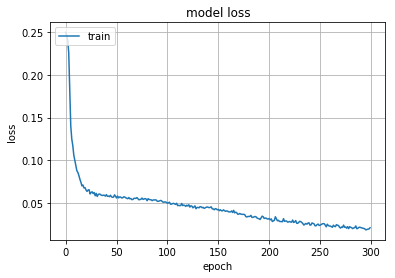

In [89]:
%matplotlib inline 
plt.plot(history.history['loss'])
#plt.plot(history.history['mean_squared_error'], label='Mean Squared Error')
plt.grid()
plt.legend(['train'], loc='upper left')
plt.title('model loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [90]:
def getResults():
    X_test = pd.read_csv("X_test.csv", index_col=0)
    X_test_big = np.array(X_test.copy(), dtype=float)
    X_test_big = np.append(X_test_big, X_test_big, axis=0)
    X_test_big = np.append(X_test_big, X_test_big, axis=0)
    
    bots = np.zeros((800, 4), dtype=np.int)
    bots[0:200, 0] = 1
    bots[200:400, 1] = 1
    bots[400:600, 2] = 1
    bots[600:800, 3] = 1
    
    X_test_big = np.append(X_test_big, bots, axis=1)
    X_test_big = np.expand_dims(X_test_big, axis=2)
    
    print(X_test_big.shape)
    
    y_test_big = model.predict_proba(X_test_big)
    
    print(y_test_big.shape)
    
    bots_list = ['A1'] * 200 + ['A2'] * 200 + ['B1'] * 200 + ['B2'] * 200
    output = pd.DataFrame(bots_list, columns=['bot'])
    output['deck'] = list(X_test.index) * 4
    output['prob'] = y_test_big
    
    def f(x):
        return x * 100
    
    output['prob'] = output['prob'].apply(f)
    print(output)
    
    output.to_csv('results.csv', sep=';', header=False, index=False)

In [91]:
getResults()

(800, 343, 1)


(800, 1)
    bot        deck          prob
0    A1  deck244804  6.423765e-04
1    A1  deck124802  9.480670e+01
2    A1  deck687350  2.080819e+01
3    A1  deck517728  8.748832e+01
4    A1  deck130762  2.268713e-02
5    A1  deck322071  1.452500e-03
6    A1  deck874296  4.445159e+00
7    A1  deck206745  9.999696e+01
8    A1  deck895482  9.999980e+01
9    A1  deck160842  7.103124e+01
10   A1  deck838916  1.665834e-01
11   A1  deck780914  8.728472e-04
12   A1  deck750047  1.074044e-01
13   A1  deck652829  9.088855e+01
14   A1  deck804465  8.914706e+01
15   A1  deck527231  4.398777e-02
16   A1  deck564938  9.945536e+01
17   A1  deck960955  9.998602e+01
18   A1  deck573326  9.998574e+01
19   A1  deck197957  4.600293e-05
20   A1  deck592549  5.079929e+01
21   A1  deck590796  9.638506e+01
22   A1  deck454901  5.176696e-01
23   A1  deck224429  9.999903e+01
24   A1  deck237007  9.067397e+01
25   A1  deck679633  1.267672e-01
26   A1  deck333404  3.430701e+00
27   A1  deck865510  2.435049e+00
28   